<a href="https://colab.research.google.com/github/VikaK0828/Data-Science/blob/main/Unit_5_Project_Study_time_to_Exam_Scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from scipy.interpolate import PchipInterpolator



In [ ]:
np.random.seed(42)
study_hours = np.random.normal(5, 1.5, 100)
exam_scores = 50 + (study_hours * 5) + np.random.normal(0, 10, 100)

data = pd.DataFrame({"StudyHours": study_hours, "ExamScores": exam_scores})

data.head()


,StudyHours,ExamScores
0,5.745071,64.571649
1,4.792604,69.756565
2,5.971533,76.430519
3,7.284545,78.399951
4,4.648770,71.630993


In this part, I generated synthetic data to simulate a study-exam scenario. I used a normal distribution to create study_hours, with a mean of 5 hours and a standard deviation of 1.5. Then, I created exam_scores based on a linear relationship with study hours, adding some noise to make it more riealistic. Finally, I organized the data into a DataFrame and displayed the first few rows to inspect the structure of the data.

<Axes: title={'center': 'Study Hours vs Exam Scores'}, xlabel='StudyHours', ylabel='ExamScores'>

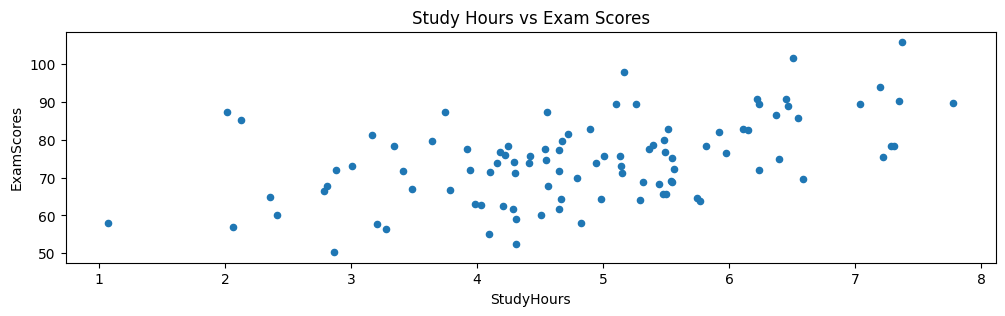

In [ ]:

data.plot(x="StudyHours", y="ExamScores", figsize=(12, 3), kind="scatter", title="Study Hours vs Exam Scores")


In this step, I created a scatter plot to visually explore the relationship between StudyHours and ExamScores. The plot helps me see how exam scores vary with the amount of time spent studying. By plotting the data points, I can quickly identify any trends, such as whether more study hours gyenerally lead to higher exam scores, and observe any outliers or patterns in the data.

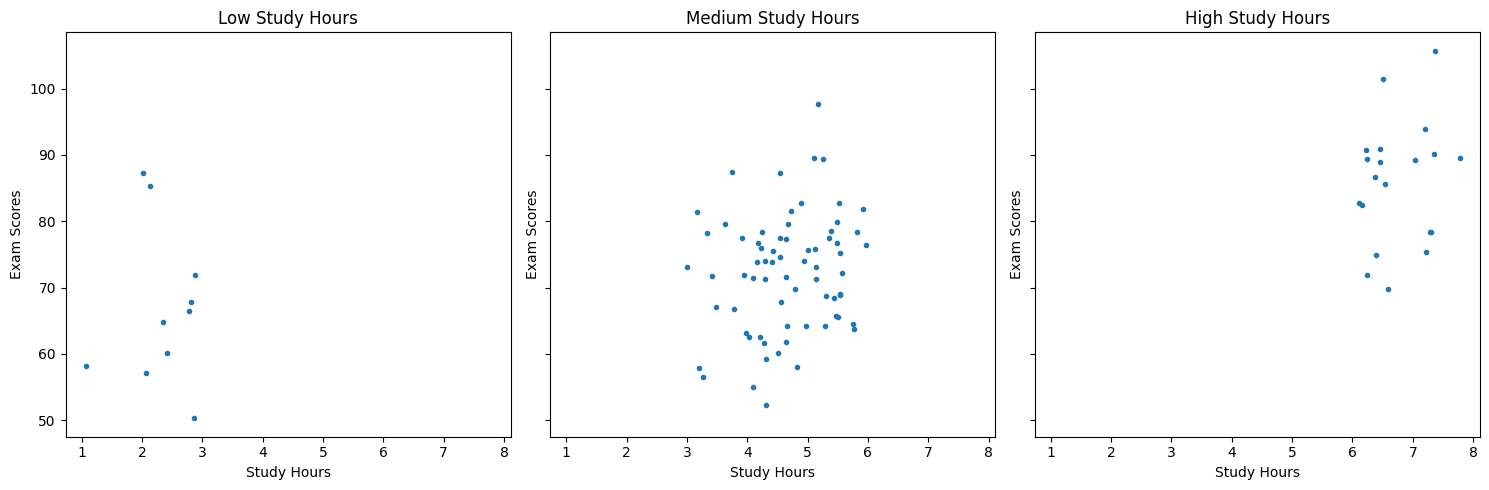

In [ ]:
data['StudyCategory'] = pd.cut(data['StudyHours'], bins=[0, 3, 6, 9], labels=['Low', 'Medium', 'High'])

study_categories = data['StudyCategory'].cat.categories

study_coords = {"StudyCategory": study_categories}

_, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

ax = np.ravel(ax)

for i, cat in enumerate(study_categories):
    ax[i].scatter(
        x=data.query('StudyCategory == @cat')['StudyHours'],
        y=data.query('StudyCategory == @cat')['ExamScores'],
        marker=".")
    ax[i].set_title(f"{cat} Study Hours")
    ax[i].set_xlabel("Study Hours")
    ax[i].set_ylabel("Exam Scores")

plt.tight_layout()
plt.show()


In this step, I categorized the study hours into three groups: Low, Medium, and High, based on predefined bins. This helps me analyze how the relationship between stuudy hours and exam scores differs across different levels of study time. I then created a series of scatter plots, one for each category, to visually compare the exam scores across these different study hour groups. By examining the plots, I can observe how the exam scores are distributed within each category and whether the relationship between study time and scores changes at different levels of study.

Output()

Output()

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

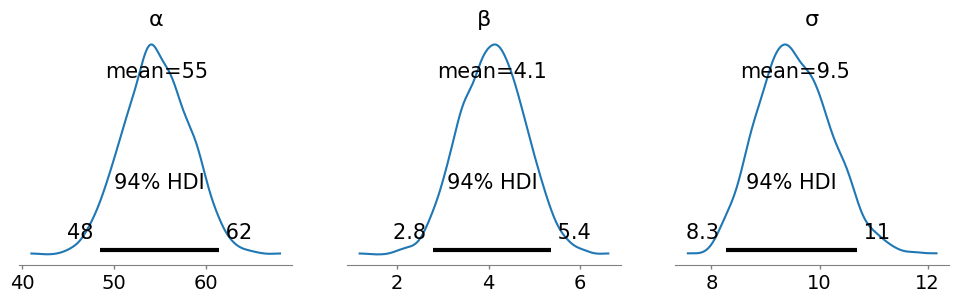

In [ ]:
with pm.Model() as model_study:

    # Priors for intercept (α) and slope (β)
    α = pm.Normal("α", mu=0, sigma=50)
    β = pm.Normal("β", mu=0, sigma=10)

    # Linear model: μ = α + β * StudyHours
    μ = pm.Deterministic("μ", α + β * data.StudyHours)

    # Prior for standard deviation (σ)
    σ = pm.HalfCauchy("σ", beta=10)

    # Likelihood: observed ExamScores
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=data.ExamScores)

    # Sampling from the posterior
    idata_study = pm.sample()

# Plot the posterior distributions
az.plot_posterior(idata_study, var_names=["~μ"], figsize=(12, 3))



In this step, I built a Bayesian linear regression model using PyMC. First, I defined priors for the intercept (α) and slope (β), which represent the relationship between study hours and exam scores. I used normal distributions for both parameters, with wide standard deviations to express uncertainty. Then, I modeled the exam scores (y_pred) as normally distributed around a predicted mean (μ), which was determined by a linear function of study hours. I also specified a prior for the standard deviation (σ) using a half-Cauchy distribution. After defining the model, I sampled from the posterior distribution to estimate the model parameters. Finally, I visualizeded the posterior distribution of the model's predicted mean (μ), which shows the uncertainty around the relationship between study hours and exam scores.

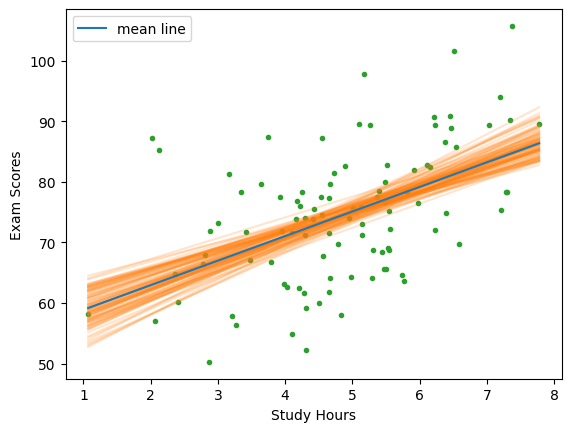

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

posterior = az.extract(idata_study, num_samples=100)

# array of x values (StudyHours) for plotting the predicted lines
x_plot = xr.DataArray(
    np.linspace(data.StudyHours.min(), data.StudyHours.max(), 50),
    dims="plot_id"
)

# I am calculating the mean prediction line using the posterior means for α and β
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

# Calculatiing the lines for each posterior sample
lines = posterior["α"] + posterior["β"] * x_plot

# Setting up ze plot
_, ax = plt.subplots()

# Plotting the predicted lines but without adding them to the legend
ax.plot(x_plot, lines.T, c="C1", alpha=0.2)  # No label for these lines

# Plotting the mean prediction line and add it to the legend
ax.plot(x_plot, mean_line, c="C0", label="mean line")

# Plotting the observed data points (StudyHours vs ExamScores) without adding to the legend
ax.plot(data.StudyHours, data.ExamScores, "C2.", zorder=-3)

# Setting labels
ax.set_xlabel("Study Hours")
ax.set_ylabel("Exam Scores")

# Removing the legend for the individual lines, only showing the mean line
plt.legend()

# Displaying the plot
plt.show()



Here, I gots 100 samples from the posterior distribution to estimate the model parameters (α and β). I then created a smooth range of study hours (x_plot) and calculated predicted exam scores using the posterior samples, including both the mean prediction line and individual posterior samples. I plotted these predicted lines with transparency to show uncertainty, added the mean line for clarity, and included the observed data points. This visualization helps to compare the model's predictions with the actual data.

Output()

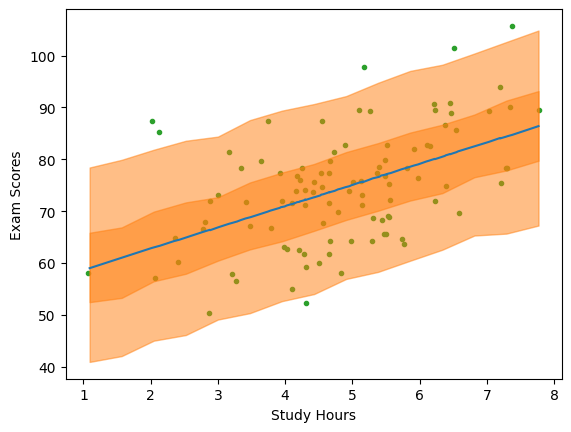

In [ ]:
from scipy.interpolate import PchipInterpolator
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Posterior predictive check
pm.sample_posterior_predictive(idata_study, model=model_study, extend_inferencedata=True)

# Calculate the mean prediction line from the posterior
mean_line = idata_study.posterior["μ"].mean(("chain", "draw"))

# Add some noise to StudyHours (similar to how we did for height)
study_hours_with_noise = np.random.normal(data.StudyHours.values, 0.01)
idx = np.argsort(study_hours_with_noise)

# Generate a smooth range of study hours for plotting
x = np.linspace(study_hours_with_noise.min(), study_hours_with_noise.max(), 15)

# Quantiles for the posterior predictive distribution
y_pred_q = idata_study.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)

# Interpolate the quantiles for each posterior sample
y_hat_bounds = iter(
    [
        PchipInterpolator(study_hours_with_noise[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

# Set up the plot
_, ax = plt.subplots()

# Plot the observed data points (StudyHours vs ExamScores)
ax.plot(data.StudyHours, data.ExamScores, "C2.", zorder=-3)

# Plot the mean prediction line
ax.plot(study_hours_with_noise[idx], mean_line[idx], c="C0")

# Fill the region between the quantiles to show uncertainty
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

# Set axis labels
ax.set_xlabel("Study Hours")
ax.set_ylabel("Exam Scores")

# Display the plot
plt.show()



In this step, I didh a posterior predictive check to evaluate how well the model predicts new data based on the posterior samples. After generating predictions from the model, I added noise to the study hours for variability, then plotted the mean prediction line along with the uncertainty intervals (from the quantiles of the posterior predictive distribution). By filling the region between these quantiles, I visualized the uncertainty in the model's predictions. This plot helps assess how well the model generalizes to unseen data.

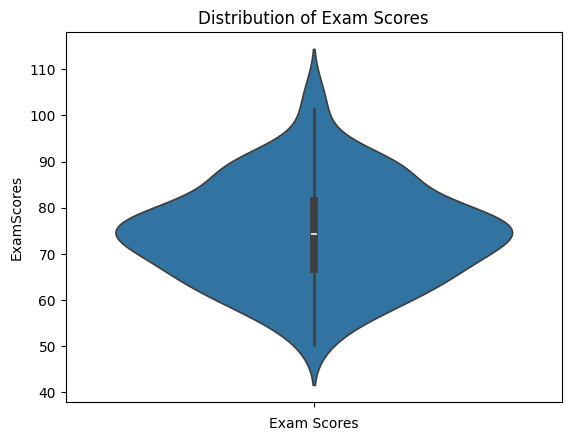

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot a violin plot for Exam Scores
sns.violinplot(data.ExamScores)

# Set axis labels and title
plt.xlabel("Exam Scores")
plt.title("Distribution of Exam Scores")

# Display the plot
plt.show()



In this step, I created a violin plot to visualize the distribution of the exam scores. The violinx plot combines aspects of a box plot and a density plot, showing the distribution of the data, its spread, and potential multimodality. It provides insights into the data's skewness, central tendency, and the presence of outliers. The x-axis represents the exam scores, and the title helps contextualize the plot, focusing on the distribution of these scores.

Output()

Output()

Output()

<Axes: xlabel='y_pred'>

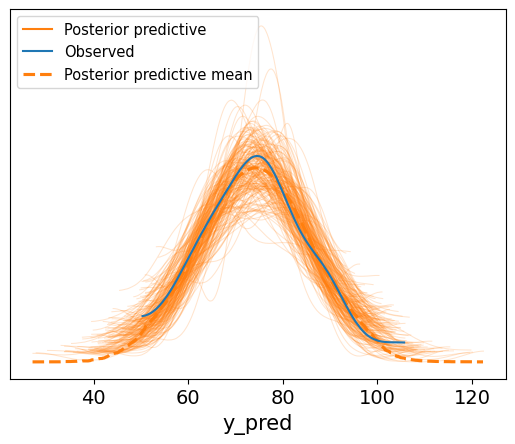

In [ ]:
import pymc as pm
import arviz as az

# Define the model
with pm.Model() as model_nh:
    # Priors for α and β
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)

    # The linear part of the model with exponential function
    μ = pm.Deterministic("μ", pm.math.exp(α + β * data.StudyHours))

    # Prior for σ (standard deviation)
    σ = pm.HalfNormal("σ", 10)

    # Likelihood of the observed data (ExamScores)
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=data.ExamScores)

    # Sampling
    idata_nh = pm.sample()

    # Posterior predictive sampling
    pm.sample_posterior_predictive(idata_nh, model=model_nh, extend_inferencedata=True)

# Plot the posterior predictive check (PPC)
az.plot_ppc(idata_nh, num_pp_samples=200, colors=["C1", "C0", "C1"])



In this step, I defined a new probabilistic model using PyMC for predicting exam scores based on study hours with an exponential relationship. First, I set normal priors for the intercept (α) and slope (β), and used an exponential function for the linear relationship between studuy hours and the predicted mean (μ). I also set a half-normal prior for the standard deviation (σ), representing the noise in the data. I then sampled from the posterior distribution using PyMC's sample() function. Afterward, I performed posterior predictive sampling to assess the model's predictions against the observed exam scores.

Finally, I plotted the posterior predictive check (PPC), using az.plot_ppc() to visualize how well the model's predicted values align with the actual data. This plot helps evaluate the model's fit by comparing the observed values (ExamScores) with the range of values predicted by the model.

###Conclusion and Prediction

The model suggests that, on average, an increase in study hours is associated with higher exam scores, with the relationship being influencied by a mix of both prior beliefs (priors for α and β) and the observed data. Given the uncertainthy intervals derived from the posterior predictive check, we can predict that future students' exam scores will likely follow the same general trend, though with variability depending on the individual circumstances, such as study efficiency and external factors.

